# Data Science Unit 2 Sprint Challenge 3

## Logistic Regression and Beyond

In this sprint challenge you will fit a logistic regression modeling the probability of an adult having an income above 50K. The dataset is available at UCI:

https://archive.ics.uci.edu/ml/datasets/adult

Your goal is to:

1. Load, validate, and clean/prepare the data.
2. Fit a logistic regression model
3. Answer questions based on the results (as well as a few extra questions about the other modules)

Don't let the perfect be the enemy of the good! Manage your time, and make sure to get to all parts. If you get stuck wrestling with the data, simplify it (if necessary, drop features or rows) so you're able to move on. If you have time at the end, you can go back and try to fix/improve.

### Hints

It has a variety of features - some are continuous, but many are categorical. You may find [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) (a method to one-hot encode) helpful!

The features have dramatically different ranges. You may find [sklearn.preprocessing.minmax_scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.minmax_scale.html#sklearn.preprocessing.minmax_scale) helpful!

## Part 1 - Load, validate, and prepare data

The data is available at: https://archive.ics.uci.edu/ml/datasets/adult

Load it, name the columns, and make sure that you've loaded the data successfully. Note that missing values for categorical variables can essentially be considered another category ("unknown"), and may not need to be dropped.

You should also prepare the data for logistic regression - one-hot encode categorical features as appropriate.

In [187]:
# Imports all in one place

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [171]:
salary = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data')
print(salary.shape)
salary.head()

(32560, 15)


,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [172]:
print(salary.columns)
salary.dtypes

Index(['39', ' State-gov', ' 77516', ' Bachelors', ' 13', ' Never-married',
       ' Adm-clerical', ' Not-in-family', ' White', ' Male', ' 2174', ' 0',
       ' 40', ' United-States', ' <=50K'],
      dtype='object')


39                 int64
 State-gov        object
 77516             int64
 Bachelors        object
 13                int64
 Never-married    object
 Adm-clerical     object
 Not-in-family    object
 White            object
 Male             object
 2174              int64
 0                 int64
 40                int64
 United-States    object
 <=50K            object
dtype: object

In [173]:
# enc = OneHotEncoder(n_values = 'auto', categorical_features = 'all', categories = 'auto', handle_unknown='ignore')
# X = salary[' State-gov']
# enc.fit(X)
cols_to_transform = [' State-gov', ' Bachelors', ' Never-married', ' Adm-clerical', ' Not-in-family',
                     ' White', ' Male', ' United-States', ' <=50K']
salary = pd.get_dummies(salary, columns = cols_to_transform)

In [174]:
salary.describe()

,39,77516,13,2174,0,40,State-gov_ ?,State-gov_ Federal-gov,State-gov_ Local-gov,State-gov_ Never-worked,...,United-States_ Scotland,United-States_ South,United-States_ Taiwan,United-States_ Thailand,United-States_ Trinadad&Tobago,United-States_ United-States,United-States_ Vietnam,United-States_ Yugoslavia,<=50K_ <=50K,<=50K_ >50K
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,...,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469,0.056388,0.029484,0.064281,0.000215,...,0.000369,0.002457,0.001566,0.000553,0.000584,0.895854,0.002058,0.000491,0.759183,0.240817
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618,0.230673,0.169161,0.245257,0.014661,...,0.019194,0.049508,0.039547,0.023506,0.024150,0.305455,0.045316,0.022162,0.427586,0.427586
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


['39' ' 77516' ' 13' ' 2174' ' 0' ' 40' ' State-gov_ ?'
 ' State-gov_ Federal-gov' ' State-gov_ Local-gov'
 ' State-gov_ Never-worked' ' State-gov_ Private'
 ' State-gov_ Self-emp-inc' ' State-gov_ Self-emp-not-inc'
 ' State-gov_ State-gov' ' State-gov_ Without-pay' ' Bachelors_ 10th'
 ' Bachelors_ 11th' ' Bachelors_ 12th' ' Bachelors_ 1st-4th'
 ' Bachelors_ 5th-6th' ' Bachelors_ 7th-8th' ' Bachelors_ 9th'
 ' Bachelors_ Assoc-acdm' ' Bachelors_ Assoc-voc' ' Bachelors_ Bachelors'
 ' Bachelors_ Doctorate' ' Bachelors_ HS-grad' ' Bachelors_ Masters'
 ' Bachelors_ Preschool' ' Bachelors_ Prof-school'
 ' Bachelors_ Some-college' ' Never-married_ Divorced'
 ' Never-married_ Married-AF-spouse' ' Never-married_ Married-civ-spouse'
 ' Never-married_ Married-spouse-absent' ' Never-married_ Never-married'
 ' Never-married_ Separated' ' Never-married_ Widowed' ' Adm-clerical_ ?'
 ' Adm-clerical_ Adm-clerical' ' Adm-clerical_ Armed-Forces'
 ' Adm-clerical_ Craft-repair' ' Adm-clerical_ Exec-manager

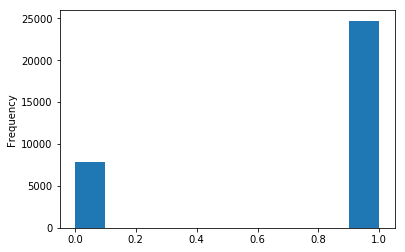

In [175]:
print(salary.columns.get_values())
salary[' <=50K_ <=50K'].plot.hist();

## Part 2 - Fit and present a Logistic Regression

Your data should now be in a state to fit a logistic regression. Use scikit-learn, define your `X` (independent variable) and `y`, and fit a model.

Then, present results - display coefficients in as interpretible a way as you can (hint - scaling the numeric features will help, as it will at least make coefficients more comparable to each other). If you find it helpful for interpretation, you can also generate predictions for cases (like our 5 year old rich kid on the Titanic) or make visualizations - but the goal is your exploration to be able to answer the question, not any particular plot (i.e. don't worry about polishing it).

It is *optional* to use `train_test_split` or validate your model more generally - that is not the core focus for this week. So, it is suggested you focus on fitting a model first, and if you have time at the end you can do further validation.

In [176]:
# Splitting data into train_test_split

X = salary[[' State-gov_ Private', ' White_ White', ' White_ Black', ' Not-in-family_ Unmarried',
            ' State-gov_ Self-emp-not-inc', ' Bachelors_ Bachelors',' Bachelors_ Doctorate',
             ' Bachelors_ HS-grad', ' Bachelors_ Masters']]
y = salary[' <=50K_ <=50K']

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)


In [178]:
print(X.shape, "\n")

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32560, 9) 

(24420, 9)
(8140, 9)
(24420,)
(8140,)


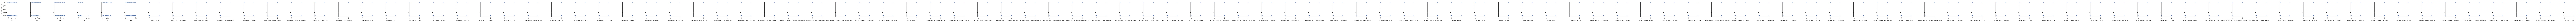

In [201]:
sns.set(style = "ticks", color_codes = True)

x_columns = salary.columns.drop(' <=50K_ <=50K', '<=50K_ >50K')

# Only plot the scatterplot of x variables with our y variable
sns.pairplot(data = salary, y_vars = [' <=50K_ <=50K'], x_vars = x_columns)

In [180]:
log_reg = LogisticRegression().fit(X, y)
log_reg.score(X, y)

/Users/danielleromanoff/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7731265356265357

In [191]:
# prediction of salary

y_pred = log_reg.predict(X_test)

Text(0.5, 257.44, 'Predicted label')

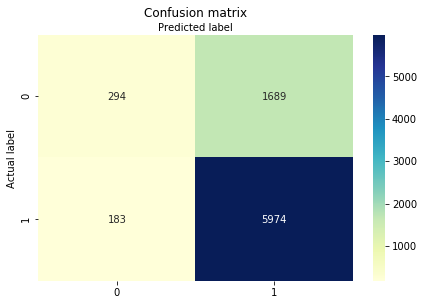

In [182]:
# Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names = [0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [199]:
# Array of coefficients from the features

log_reg.coef_.tolist()


[[0.23905976776731627,
  -0.37311645412587535,
  0.24457557022971815,
  1.5339758454783052,
  -0.0252453206795377,
  -1.095377178434555,
  -2.4270462589106567,
  0.15724128988956101,
  -1.6680361192077353]]

In [198]:
# Intercept
print('Intercept for model is ', log_reg.intercept_)


Intercept for model is  [1.52471249]


In [188]:
# The logistic sigmoid "squishing" function, implemented to accept numpy arrays
def sigmoid(x):
  return 1 / (1 + np.e**(-x))

In [189]:
sigmoid(log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(X_test)))

array([[0.9561388 , 0.78731853, 0.71360766, ..., 0.80069692, 0.96954289,
        0.57328793]])

## Part 3 - Analysis, Interpretation, and Questions

### Based on your above model, answer the following questions

1. What are 3 features positively correlated with income above 50k?
2. What are 3 features negatively correlated with income above 50k?
3. Overall, how well does the model explain the data and what insights do you derive from it?

*These answers count* - that is, make sure to spend some time on them, connecting to your analysis above. There is no single right answer, but as long as you support your reasoning with evidence you are on the right track.

Note - scikit-learn logistic regression does *not* automatically perform a hypothesis test on coefficients. That is OK - if you scale the data they are more comparable in weight.

### Match the following situation descriptions with the model most appropriate to addressing them

In addition to logistic regression, a number of other approaches were covered this week. Pair them with the situations they are most appropriate for, and briefly explain why.

Situations:
1. You are given data on academic performance of primary school students, and asked to fit a model to help predict "at-risk" students who are likely to receive the bottom tier of grades.
2. You are studying tech companies and their patterns in releasing new products, and would like to be able to model and predict when a new product is likely to be launched.
3. You are working on modeling expected plant size and yield with a laboratory that is able to capture fantastically detailed physical data about plants, but only of a few dozen plants at a time.

Approaches:
1. Ridge Regression
2. Quantile Regression
3. Survival Analysis

**1. Ridge Regression**
**2. Quantile Regression**
**3. Survival Analysis**

What are 3 features positively correlated with income above 50k?
What are 3 features negatively correlated with income above 50k?
Overall, how well does the model explain the data and what insights do you derive from it?

**TODO - your answers!**